In [1]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
data=pd.read_csv('order_train1.csv')
data.columns=['订单日期', '销售区域编码', '产品编码', '产品大类编码',
       '产品细类编码', '销售渠道名称', '产品价格', '订单需求量']
data.head()

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,订单需求量
0,2015-09-01,104,22069,307,403,offline,1114.0,19
1,2015-09-01,104,20028,301,405,offline,1012.0,12
2,2015-09-02,104,21183,307,403,online,428.0,109
3,2015-09-02,104,20448,308,404,online,962.0,3
4,2015-09-02,104,21565,307,403,offline,1400.0,3


In [3]:
data['订单日期']=pd.to_datetime(data['订单日期'], format='%Y-%m-%d')
data['日']=data['订单日期'].dt.day
data['周']=data['订单日期'].dt.week
data['月']=data['订单日期'].dt.month
data=data[['订单日期','日', '周', '月','销售区域编码', '产品编码', '产品大类编码', '产品细类编码','订单需求量']]
data['组合']=(data['销售区域编码'].map(str)+data['产品编码'].map(str))
temp=pd.read_csv('predict_sku1.csv')
temp.columns=['销售区域编码', '产品编码', '产品大类编码', '产品细类编码']
temp.head()

,销售区域编码,产品编码,产品大类编码,产品细类编码
0,101,20002,303,406
1,101,20003,301,405
2,101,20006,307,403
3,101,20011,303,401
4,101,20014,307,403


In [4]:
temp['组合']=(temp['销售区域编码'].map(str)+temp['产品编码'].map(str))
data['年月']=data['订单日期'].map(str).apply(lambda x:x[:7])

In [5]:
def calculate_metrics(train_y, train_pred):
    mae = mean_absolute_error(train_y, train_pred)
    mse = mean_squared_error(train_y, train_pred)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

In [9]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) 

In [8]:
data['年周']=data['订单日期'].dt.year.map(str)+'-'+data['订单日期'].dt.week.map(str)

In [34]:
%%time
ttt=[]
count=0
mae_list = []
rmse_list = []
print("\nXGBOOST回归:")
for i in temp['组合']:
    count+=1
    if count%20==0:
        print(count)
    try:
        aa=data[data['组合']==i].groupby('订单日期').sum()['订单需求量'].values
        aa=pd.DataFrame(aa,columns=['订单需求量'])
        aa['shift1']=aa['订单需求量'].shift(1)
        aa['shift2']=aa['订单需求量'].shift(2)
        aa['shift3']=aa['订单需求量'].shift(3)
        aa.dropna(inplace=True)
        X=aa[['shift1', 'shift2', 'shift3']]
        Y=aa['订单需求量']
        tr_x,te_x,tr_y,te_y=train_test_split(X ,Y,test_size=0.1,random_state=5) 
        model=xgb.XGBRegressor()
        model.fit(tr_x,tr_y)
        y_pred = model.predict(te_x)
        train_pred = model.predict(tr_x)
        
        mae, mse, rmse = calculate_metrics(tr_y, train_pred)
        mae_list.append(mse)
        rmse_list.append(rmse)
        
        x_input=Y.tolist()[-3:]
        predict_forword_number=90
        predict_list=[]
        
        while len(predict_list) < predict_forword_number:
            yhat =model.predict(np.array(x_input).reshape(1,-1))
            predict_list.append(yhat[0])
            x_input=x_input[-2:]+[yhat[0]]

        ttt.append([i,mape(model.predict(tr_x),tr_y),mape(model.predict(te_x),te_y),predict_list])
    except:
        continue


XGBOOST回归:
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
2420
2440
2460
2480
2500
2520
2540
2560
2580
2600
Wall time: 8min 16s


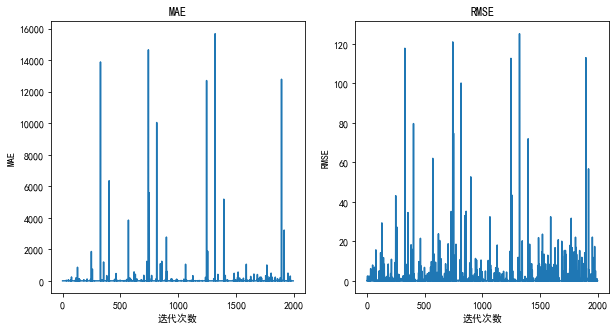

In [35]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(mae_list)
plt.title('MAE')
plt.xlabel('迭代次数')
plt.ylabel('MAE')

plt.subplot(1, 2, 2)
plt.plot(rmse_list)
plt.title('RMSE')
plt.xlabel('迭代次数')
plt.ylabel('RMSE')

plt.show()

In [36]:
tad=[]
for l in ttt:
    tad.append(l[:3])
tad=pd.DataFrame(tad,columns=['标识','训练集Mape','测试集Mape'])    
tad2=[]
for l in ttt:
    tad2.append(l[3])
tad2=pd.DataFrame(tad2)

tad['2019年1月预测需求量']=tad2[tad2.columns[:31]].sum(axis=1)
tad['2019年2月预测需求量']=tad2[tad2.columns[31:59]].sum(axis=1)
tad['2019年3月预测需求量']=tad2[tad2.columns[51:90]].sum(axis=1)

In [37]:
ttt_3=tad
ttt_3

,标识,训练集Mape,测试集Mape,2019年1月预测需求量,2019年2月预测需求量,2019年3月预测需求量
0,10120002,0.000129,0.253494,349.830118,321.535332,444.200970
1,10120003,0.000413,4.765406,3989.474098,2781.312044,4423.372459
2,10120006,0.000035,5.870019,1974.464196,1258.383326,1824.705070
3,10120014,0.010881,2.670774,12406.372803,11011.595015,20773.196991
4,10120016,0.040092,1.077220,4637.293388,3725.857956,6210.673431
...,...,...,...,...,...,...
1967,10522059,0.000113,0.102159,356.583781,342.735027,478.496788
1968,10522066,0.024811,3.849449,16235.634228,15213.016216,20062.666468
1969,10522072,0.000022,5.489137,2622.147446,2603.978308,3463.232567
1970,10522083,0.003644,0.763426,2394.587674,2336.379478,3076.469095


In [40]:
ttt_3['sales_region_code']=ttt_3['标识'].apply(lambda x:x[:3])
ttt_3['item_code']=ttt_3['标识'].apply(lambda x:x[3:])
ttt_3[['sales_region_code', 'item_code','2019年1月预测需求量', '2019年2月预测需求量',
       '2019年3月预测需求量']].to_excel('result1_日.xlsx',index=None)

In [39]:
ttt_3[['训练集Mape','测试集Mape']].mean()

训练集Mape    0.017077
测试集Mape    3.020376
dtype: float64

In [ ]:
%%time
ttt=[]
count=0
mae_list = []
rmse_list = []
print("\n随机森林回归:")
for i in temp['组合']:
    count+=1
    if count%20==0:
        print(count)
    try:
        aa=data[data['组合']==i].groupby('订单日期').sum()['订单需求量'].values
        aa=pd.DataFrame(aa,columns=['订单需求量'])
        aa['shift1']=aa['订单需求量'].shift(1)
        aa['shift2']=aa['订单需求量'].shift(2)
        aa['shift3']=aa['订单需求量'].shift(3)
        aa.dropna(inplace=True)
        X=aa[['shift1', 'shift2', 'shift3']]
        Y=aa['订单需求量']
        tr_x,te_x,tr_y,te_y=train_test_split(X ,Y,test_size=0.1,random_state=5) 
        rf=RandomForestRegressor(max_depth=20,n_estimators=1000,random_state=0)
        rf.fit(tr_x,tr_y)
        y_pred = rf.predict(te_x)
        train_pred = rf.predict(tr_x)
        
        mae, mse, rmse = calculate_metrics(tr_y, train_pred)
        mae_list.append(mse)
        rmse_list.append(rmse)
        
        x_input=Y.tolist()[-3:]
        predict_forword_number=90
        predict_list=[]
        
        while len(predict_list) < predict_forword_number:
            yhat =rf.predict(np.array(x_input).reshape(1,-1))
            predict_list.append(yhat[0])
            x_input=x_input[-2:]+[yhat[0]]

        ttt.append([i,mape(rf.predict(tr_x),tr_y),mape(rf.predict(te_x),te_y),predict_list])
    except:
        continue


随机森林回归:
